# Probit regression

Testing probit regression with identity covariance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from time import time

import cvxpy as cv
from statsmodels.discrete.discrete_model import Probit
import sklearn.linear_model as linear_model
from scipy.special import erfcinv
from scipy.stats import norm

from state_evolution.models.probit_regression import ProbitRegression # logistic regression task
from state_evolution.models.logistic_regression import LogisticRegression # logistic regression task
from state_evolution.models.bayes_optimal_probit import BayesOptimalProbit
from state_evolution.algorithms.state_evolution import StateEvolution # Standard SP iteration
from state_evolution.auxiliary.utility import *
from state_evolution.data_models.custom import Custom # Custom data model. You input the covariances

sys.path.append('../overparametrized-uncertainty/Code/')
import core.data as data


%load_ext autoreload
%autoreload 2

/Users/clarte/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# empirical probit 

def get_empirical_probit(X, y, lambda_):
    w = cv.Variable(d)
    error = - cv.sum(cv.log_normcdf(cv.multiply(y, X @ w))) + lambda_ / 2 * cv.sum_squares(w)
    obj = cv.Minimize(error)
    prob = cv.Problem(obj)
    prob.solve()

    weight = w.value
    return weight

def run_statsmodel_probit(X, y, lambda_):
    y_probit = (1. + y) / 2.
    pr = Probit(y_probit, X)
    res = pr.fit()
    return res.params
    

In [9]:
alpha   = 3.0
sigma   = 2.0
lambda_ = 1.0
d = 256

# Covariances

Omega = Psi = Phi = np.eye(d)

theta, X, y = data.ProbitModelData(covariance = Omega, teacher_covariance = np.eye(d), sigma = sigma).sample_instance(alpha)

In [10]:
data_model = Custom(teacher_teacher_cov = Psi,
                    student_student_cov = Omega,
                    teacher_student_cov = Phi,
                    teacher_weights     = theta)

In [11]:
task = ProbitRegression(sample_complexity = alpha,
                        regularisation    = lambda_,
                        data_model        = data_model,
                        Delta             = sigma**2)

sp = StateEvolution(model = task,
                    initialisation = 'uninformed',
                    tolerance = 1e-5,
                    damping = 0.5,
                    verbose = True,
                    max_steps = 1000)

sp.iterate()

t: 0, diff: 49.52498988378246, self overlaps: 0.0015523920227352812, teacher-student overlap: 0.012419346159557828
t: 1, diff: 24.784020567571595, self overlaps: 0.003937117065001124, teacher-student overlap: 0.02691877534447518
t: 2, diff: 12.428303511761985, self overlaps: 0.01064304770288397, teacher-student overlap: 0.04785497432669789
t: 3, diff: 6.2703620225538765, self overlaps: 0.026343591937591344, teacher-student overlap: 0.07759369473601643
t: 4, diff: 3.212321990140201, self overlaps: 0.056835318034986246, teacher-student overlap: 0.1163324018767637
t: 5, diff: 1.6969056980014934, self overlaps: 0.10507114940833845, teacher-student overlap: 0.16113673452611005
t: 6, diff: 0.938770585853943, self overlaps: 0.16734918060055998, teacher-student overlap: 0.20672567754584523
t: 7, diff: 0.5462840146053378, self overlaps: 0.23436330521287402, teacher-student overlap: 0.2477558051774641
t: 8, diff: 0.33053712281762543, self overlaps: 0.296211793080287, teacher-student overlap: 0.2

In [12]:
weight = get_empirical_probit(X, y, lambda_)
sm_weight = run_statsmodel_probit(X, y, lambda_)

Optimization terminated successfully.
         Current function value: 0.360715
         Iterations 8


In [13]:
print(np.mean(weight**2), np.mean(sm_weight**2))
print(np.mean(weight* theta), np.mean(sm_weight*theta))

0.377412043626801 5.168088688999603
0.30236737201783564 1.067489092810622


In [14]:
print('For PROBIT : ')

info = sp.get_info()
print('Info of state evolution : ', info)
print('theory : q = ', info['overlaps']['self_overlap'],', m = ', info['overlaps']['teacher_student'])

exp_q   = np.mean(weight * weight)
exp_m   = np.mean(weight * theta)
exp_rho = np.mean(theta * theta)
print(f'experiment : q = {exp_q}, m = {exp_m}')
print('theoretical angle : ', info['overlaps']['teacher_student'] / (np.sqrt(info['overlaps']['self_overlap'])))
print('experimental angle : ', exp_m / np.sqrt(exp_q * exp_rho))

For PROBIT : 
Info of state evolution :  {'hyperparameters': {'initialisation': 'uninformed', 'damping': 0.5, 'max_steps': 1000, 'tolerance': 1e-05}, 'status': 1, 'convergence_time': 30, 'test_error': 0.42521856941969466, 'overlaps': {'variance': 0.5454982834241912, 'self_overlap': 0.4611141278795197, 'teacher_student': 0.3509535787680697}, 'test_loss': 0.6848165856194328, 'train_loss': 0.4481467595234181, 'calibration': -1.0}
theory : q =  0.4611141278795197 , m =  0.3509535787680697
experiment : q = 0.377412043626801, m = 0.30236737201783564
theoretical angle :  0.5168273179389375
experimental angle :  0.5104903554450302


In [17]:
lr_lambda_ = lambda_

lr_task = LogisticRegression(sample_complexity = alpha,
                        regularisation    = lr_lambda_,
                        data_model        = data_model,
                        Delta             = sigma**2)

lr_sp = StateEvolution(model = lr_task,
                    initialisation = 'uninformed',
                    tolerance = 1e-7,
                    damping = 0.5,
                    verbose = False,
                    max_steps = 1000)
lr_sp.iterate()

if lr_lambda_ > 0.0:
    lr = linear_model.LogisticRegression('l2', C=1. / lr_lambda_, fit_intercept=False)
else:
    lr = linear_model.LogisticRegression('none', fit_intercept=False)
lr.fit(X, y)

LogisticRegression(fit_intercept=False, penalty='none')

In [18]:
print('====')
print('For LOGISTIC')

lr_info = lr_sp.get_info()
print('theory : q = ', lr_info['overlaps']['self_overlap'],', m = ', lr_info['overlaps']['teacher_student'])
exp_q = np.mean(lr.coef_ * lr.coef_)
exp_m = np.mean(theta * lr.coef_)
print(f'experiment : q = {exp_q}, m = {exp_m}')

print('theoretical angle : ', lr_info['overlaps']['teacher_student'] / (np.sqrt(lr_info['overlaps']['self_overlap'])))
print('experimental angle : ', exp_m / np.sqrt(exp_q))

====
For LOGISTIC
theory : q =  3.135376344600548 , m =  1.088864275804279
experiment : q = 2.9795573379619453, m = 1.0516999948739671
theoretical angle :  0.6149345729570587
experimental angle :  0.609278703393386


### Running as a function of alpha 

Fix the level, compute the calibration

In [46]:
# FOR PROBIT 

alpha_range  = np.linspace(10.0, 100.0, 10)
sigma   = 2.0
lambda_ = 0.0

pr_m_list, pr_q_list = [], []

for alpha in alpha_range:
    print(alpha)
    
    theta, X, y = data.ProbitModelData(covariance = Omega, teacher_covariance = np.eye(d), sigma = sigma).sample_instance(alpha)
    
    task = ProbitRegression(sample_complexity = alpha,
                            regularisation    = lambda_,
                            data_model        = data_model,
                            Delta             = sigma**2)

    sp = StateEvolution(model = task,
                        initialisation = 'uninformed',
                        tolerance = 1e-5,
                        damping = 0.5,
                        verbose = False,
                        max_steps = 1000)

    sp.iterate()
    info = sp.get_info()
    print('done with se')
    
    m, q = info['overlaps']['teacher_student'], info['overlaps']['self_overlap']
    
    pr_m_list.append(m)
    pr_q_list.append(q)  

10.0
Hat :  0.08910767276301564 0.0053991643750022494 0.08105335493119846
V, q, m :  11.222378152098399 1.5029270896992846 0.9047234508211093
Hat :  0.15102719219674174 0.014445867777965948 0.13425933089066472
V, q, m :  6.621324183113388 1.4193638605070724 0.8841975012543488
Hat :  0.24870673086252834 0.03733676250797686 0.2169371231983003
V, q, m :  4.020799905703983 1.3603675092248337 0.8675735256593368
Hat :  0.39482628080115056 0.0919371140284568 0.3405273707396146
V, q, m :  2.5327594656841943 1.3296286843334744 0.8578392739596262
Hat :  0.5991904594954488 0.2122674118447314 0.5159031510940458
V, q, m :  1.6689184284443632 1.3285638888301645 0.8563735474273287
Hat :  0.862168528702114 0.4515445017509691 0.7482794134531756
V, q, m :  1.1598660432495418 1.3566673550706332 0.863240056119591
Hat :  1.1684964516600638 0.8697992340945693 1.0304979493411843
V, q, m :  0.8558006304420664 1.4106060132594171 0.8771617535636116
Hat :  1.4884687383964197 1.4971411302456155 1.339242427891437


Hat :  4.5115199817345975 6.227239723292543 3.9609027765991778
V, q, m :  0.22165478686753334 1.0726090926899106 0.8732352334058096
Hat :  5.382089829462617 8.16081923464348 4.510341293613393
V, q, m :  0.18580143247067402 0.9802460477861428 0.8335245906009666
Hat :  6.36032634861909 9.614117022629138 4.8898828248130295
V, q, m :  0.15722463678567583 0.8255496837411949 0.7646787218952226
Hat :  7.4711722754154675 10.475608535632189 5.121938111925255
V, q, m :  0.13384780368277485 0.6551401419245042 0.6818761948707784
Hat :  8.699793301451315 10.856413229618223 5.249499077136543
V, q, m :  0.11494525965728154 0.5055805084433529 0.6001625368021131
Hat :  10.01513756494612 10.946754246459449 5.31386130059213
V, q, m :  0.09984885315006453 0.3891423675201652 0.5277317805653328
Hat :  11.386037599579932 10.905847256087041 5.3446853119046285
V, q, m :  0.08782686612916975 0.30328173593305807 0.466884524717677
Hat :  12.786762390401982 10.830120251852891 5.359699045205622
V, q, m :  0.0782058

Hat :  49.6110033942297 11.394804318837656 5.4610926910687265
V, q, m :  0.020156818681000728 0.01668178702241424 0.10948673129250691
Hat :  49.74441086733492 11.396587405832193 5.461244771501498
V, q, m :  0.02010276094468049 0.016593818868432114 0.10919614417517913
Hat :  49.87192455873668 11.398284258314206 5.4613894295535115
V, q, m :  0.020051361740055763 0.016510386514379943 0.10891983394964201
Hat :  49.993802756818155 11.399899343234708 5.461527056014177
V, q, m :  0.02000247920455741 0.016431228838963 0.10865704005378414
Hat :  50.110292627726096 11.401436869912773 5.4616580185399615
V, q, m :  0.019955980050427775 0.016356102220495983 0.10840704778402468
Hat :  50.22163067505218 11.4029008071652 5.4617826632488145
V, q, m :  0.019911738957069637 0.01628477914528151 0.10816918505542769
Hat :  50.32804318250683 11.404294899108145 5.461901316185442
V, q, m :  0.01986963801421119 0.016217046945790205 0.10794281943190254
Hat :  50.42974663998791 11.405622679748832 5.46201428466954

Hat :  52.49450373526699 11.4316360955382 5.464219680321511
V, q, m :  0.019049613366059454 0.014925170239861911 0.1035319204280506
Hat :  52.500049220752345 11.43170362124704 5.464225386016098
V, q, m :  0.019047601189766453 0.014922064369141976 0.10352109263386074
Hat :  52.505347903032344 11.431768130361064 5.464230836727875
V, q, m :  0.01904567896296611 0.014919097632432907 0.10351074885023928
Hat :  52.51041076309775 11.43182975808746 5.464236043893379
V, q, m :  0.019043842648870705 0.014916263760026992 0.10350086735730821
Hat :  52.5152482936295 11.431888633534435 5.464241018432576
V, q, m :  0.019042088393235453 0.014913556767961439 0.1034914274172083
Hat :  52.51987052068969 11.431944879989691 5.4642457707724965
V, q, m :  0.01904041251598402 0.014910970944715711 0.10348240922906005
Hat :  52.5242870244513 11.431998615185904 5.464250310869784
V, q, m :  0.019038811503228524 0.014908500838552318 0.10347379388604563
Hat :  52.52850695900875 11.43204995155387 5.464254648232179
V

Hat :  19456.15753273116 18.223196276914 8.285740100338177
V, q, m :  5.1397610155946604e-05 2.285288005919621e-07 0.0004235787708214445
Hat :  22461.34845551962 18.22405281952261 8.285793146617985
V, q, m :  4.452092455536709e-05 1.7147157107859102e-07 0.00036690887326598697
Hat :  25930.351238545627 18.22479482426848 8.285839093896087
V, q, m :  3.8564845913598505e-05 1.2866324650117776e-07 0.00031782499505719715
Hat :  29934.749138342668 18.22543760915227 8.285878892979257
V, q, m :  3.340599232612661e-05 9.654428679319776e-08 0.0002753105864141738
Hat :  34557.17334896843 18.225994443131412 8.285913367134713
V, q, m :  2.8937551978042525e-05 7.244477189177572e-08 0.0002384855828663181
Hat :  39893.008105843764 18.226476820323096 8.285943229246195
V, q, m :  2.5067049277076545e-05 5.436192090045286e-08 0.00020658801432365086
Hat :  46052.35895001137 18.22689469748795 8.285969096650328
V, q, m :  2.1714414262371957e-05 4.0793300130693256e-08 0.00017895810868951928
Hat :  53162.324768

done with se
50.0
Hat :  0.44553836381507816 0.026995821875011244 0.40526677465599226
V, q, m :  2.244475630419679 0.9589428293740669 0.9047234508211093
Hat :  0.8144078691109249 0.0801055824771251 0.7203570632193468
V, q, m :  1.2278859744954116 0.8989404593030866 0.8797632383639198
Hat :  1.4404536743922745 0.23137453987722073 1.2444303721103238
V, q, m :  0.6942257274756847 0.8538503045564172 0.8592731857711682
Hat :  2.438889919823713 0.6355282836810587 2.0784527655376164
V, q, m :  0.4100226057239524 0.8292077195787653 0.847633112017717
Hat :  3.905700476266872 1.6169641700428508 3.323867552958177
V, q, m :  0.2560360186544094 0.8263590432736632 0.8464566640066061
Hat :  5.845799870407697 3.6993287838802704 5.022799724113294
V, q, m :  0.17106298918342175 0.8425353145946394 0.8545979989051219
Hat :  8.123453398621528 7.385916549375999 7.071657883615102
V, q, m :  0.12310035534514062 0.8656630546098991 0.8658456944645091
Hat :  10.587075432115139 12.597838482264606 9.18769435844391

Hat :  769.1391396840277 35.57950743825392 16.438534622807122
V, q, m :  0.0013001548723821448 0.0005144788374106788 0.02125779143075543
Hat :  1124.790613448456 35.823387854363844 16.429742578518386
V, q, m :  0.0008890543609126818 0.00024053142840680628 0.01452844148811137
Hat :  1645.414057320536 36.00597837829992 16.42125155909376
V, q, m :  0.0006077497609498024 0.00011236457305114294 0.00992638245047328
Hat :  2407.5201835155804 36.13951152011514 16.41305941713886
V, q, m :  0.00041536515741261615 5.2462452940272806e-05 0.006780778501469418
Hat :  3523.107281209377 36.23549370463084 16.405225282676547
V, q, m :  0.0002838403489253753 2.448547465398853e-05 0.004631442577077047
Hat :  5156.120439451329 36.30360327617843 16.397816163785116
V, q, m :  0.00019394426715649244 1.1425257024800663e-05 0.0031631727676990954
Hat :  7546.544731551394 36.35147163103171 16.390882545120558
V, q, m :  0.00013251097496568123 5.330412799572726e-06 0.0021603003733856553
Hat :  11045.673076703051 36

Hat :  3.9835985829181135 1.049359570284884 3.3920913925507796
V, q, m :  0.25102930909958004 0.7873065249079774 0.8469386041098388
Hat :  6.412397590188647 2.694472201679778 5.453099868215165
V, q, m :  0.15594790964460165 0.7848221197720614 0.845829761708606
Hat :  9.633253891738656 6.203484384561239 8.271221635807464
V, q, m :  0.10380708442217906 0.8001001949064854 0.8539975109075126
Hat :  13.423477604194826 12.409128199456497 11.662792080887446
V, q, m :  0.07449634360677895 0.8196854508491741 0.8641665343813661
Hat :  17.58185720597598 21.094169923478674 15.135959964064622
V, q, m :  0.056876812744225076 0.8053797555784898 0.8562590504469011
Hat :  22.53993734794168 30.394143594408316 18.096213456159404
V, q, m :  0.044365695634523084 0.7009314294055893 0.7985368439221836
Hat :  29.654062497634577 37.79178312704883 20.17047658996803
V, q, m :  0.033722192366720985 0.503152202250684 0.6765375627098232
Hat :  40.96035384328829 41.970329006283045 21.343213211799316
V, q, m :  0.024

Hat :  484647.22356854076 54.68339643950269 24.480835800505176
V, q, m :  2.0633565021518717e-06 2.770632224547109e-09 5.024125334510472e-05
Hat :  779044.8147725867 54.685424100649556 24.478597754175365
V, q, m :  1.2836232024622523e-06 1.0720969809239546e-09 3.125244846100627e-05
Hat :  1252277.202808417 54.68669390847268 24.476848479641628
V, q, m :  7.985452404286782e-07 4.1486041623881065e-10 1.9440837853936394e-05
Hat :  2012979.3952015392 54.687488050121985 24.475483842754752
V, q, m :  4.967760735076377e-07 1.605389664996956e-10 1.2093497232126112e-05
Hat :  3235777.834444719 54.687984179174116 24.474420905587465
V, q, m :  3.0904470305564316e-07 6.212515860829539e-11 7.523045389510541e-06
Hat :  5201377.563149775 54.68829386578565 24.47359399262425
V, q, m :  1.9225676041760644e-07 2.4041494916342952e-11 4.679929644398024e-06
done with se
100.0
Hat :  0.8910767276301563 0.05399164375002249 0.8105335493119845
V, q, m :  1.1222378152098396 0.8909447968334145 0.9047234508211093
H

In [47]:
pr_exp_m_list, pr_exp_q_list = [], []

for alpha in alpha_range:
    print(alpha)
    
    theta, X, y = data.ProbitModelData(covariance = Omega, teacher_covariance = np.eye(d), sigma = sigma).sample_instance(alpha)
        
    weight = get_empirical_probit(X, y, lambda_)
    exp_m, exp_q = np.mean(theta * weight), np.mean(weight * weight)

    pr_exp_m_list.append(exp_m)
    pr_exp_q_list.append(exp_q)    

10.0


KeyboardInterrupt: 

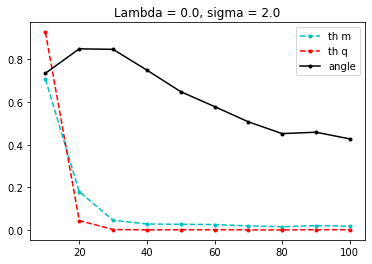

In [43]:
plt.plot(alpha_range, pr_m_list, 'c--',marker='.', label='th m')
plt.plot(alpha_range, pr_q_list, 'r--', marker='.', label='th q')

plt.plot(alpha_range, np.array(pr_m_list) / np.sqrt(np.array(pr_q_list)), 'k', marker='.', label='angle')

#plt.plot(alpha_range, pr_exp_m_list, 'c', marker='.', label='exp m')
#plt.plot(alpha_range, pr_exp_q_list, 'r', marker='.', label='exp q')

plt.title(f'Lambda = {lambda_}, sigma = {sigma}')
plt.legend()

In [49]:
# FOR LOGISTIC

alpha_range  = np.linspace(10.0, 100.0, 10)
sigma   = 2.0
lambda_ = 0.0

m_list, q_list, exp_m_list, exp_q_list = [], [], [], []

for alpha in alpha_range:
    print(alpha)
    
    theta, X, y = data.ProbitModelData(covariance = Omega, teacher_covariance = np.eye(d), sigma = sigma).sample_instance(alpha)
    
    task = LogisticRegression(sample_complexity = alpha,
                            regularisation    = lambda_,
                            data_model        = data_model,
                            Delta             = sigma**2)

    sp = StateEvolution(model = task,
                        initialisation = 'uninformed',
                        tolerance = 1e-5,
                        damping = 0.5,
                        verbose = False,
                        max_steps = 1000)

    sp.iterate()
    info = sp.get_info()
    print('done with se')
    
    m, q, rho = info['overlaps']['teacher_student'], info['overlaps']['self_overlap'], 1.0
    
    if lambda_ > 0.0:
        lr = linear_model.LogisticRegression('l2', C=1. / lambda_, fit_intercept=False)
    else:
        lr = linear_model.LogisticRegression('none', fit_intercept=False)
    lr.fit(X, y)
    weight = lr.coef_
    
    exp_m, exp_q = np.mean(theta * weight), np.mean(weight**2)

    m_list.append(m)
    q_list.append(q)
    exp_m_list.append(exp_m)
    exp_q_list.append(exp_q)    

10.0
done with se
20.0
done with se
30.0
done with se
40.0
done with se
50.0
done with se
60.0
done with se
70.0
done with se
80.0
done with se
90.0
done with se
100.0
done with se


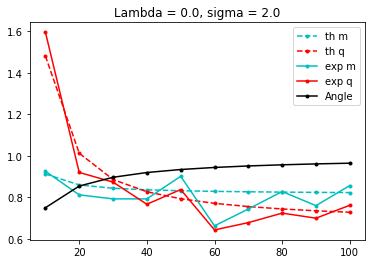

In [54]:
plt.plot(alpha_range, m_list, 'c--',marker='.', label='th m')
plt.plot(alpha_range, q_list, 'r--', marker='.', label='th q')

plt.plot(alpha_range, exp_m_list, 'c', marker='.', label='exp m')
plt.plot(alpha_range, exp_q_list, 'r', marker='.', label='exp q')

plt.plot(alpha_range, np.array(m_list) / np.sqrt(np.array(q_list)), 'k', marker='.', label='Angle')

plt.title(f'Lambda = {lambda_}, sigma = {sigma}')
plt.legend()

### Some plots

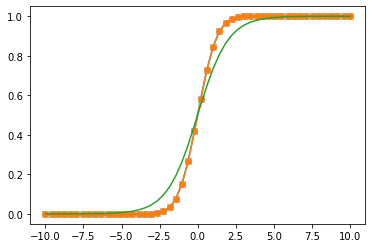

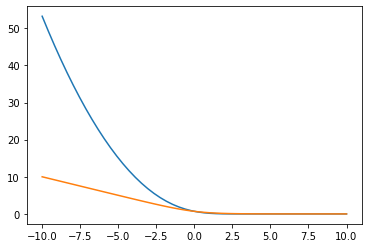

In [7]:
vals = np.linspace(-10.0, 10.0, 50)

def cdf(x):
    return 0.5 * erfc(- x / np.sqrt(2.0))

def approx_cdf(z):
    return 1.0 / (1.0 + 2*np.exp(-np.sqrt(2*np.pi)*z))

def logistic(x):
    return 1. / (1 + np.exp(-x))

def f_0(z):
    return - np.log( cdf(z) )

def f_1(z):
    return np.log(1 + np.exp(-z))

plt.plot(vals, cdf(vals), marker='x')
plt.plot(vals, norm.cdf(vals), marker='o')
plt.plot(vals, logistic(vals))
plt.show()

plt.plot(vals, f_0(vals))
plt.plot(vals, f_1(vals))
plt.show()

/var/folders/bh/679xzk357893hjh_yn8vw93h0000gq/T/ipykernel_61975/3151738842.py:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(vals2, norm.pdf(vals2) / cdf(-vals2)); plt.show()
/var/folders/bh/679xzk357893hjh_yn8vw93h0000gq/T/ipykernel_61975/3151738842.py:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(vals2, norm.pdf(vals2) / cdf(-vals2)); plt.show()


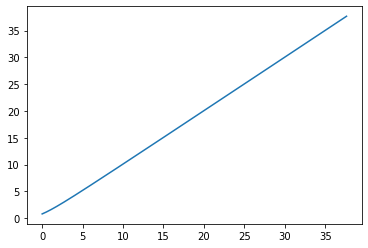

In [13]:
def d2loss(z):
    return (4*np.cosh(z/2)**2)

vals2 = np.linspace(0, 100, 1000)
plt.plot(vals2, norm.pdf(vals2) / cdf(-vals2)); plt.show()

nan 4.56986530030502


/var/folders/bh/679xzk357893hjh_yn8vw93h0000gq/T/ipykernel_47466/1727832809.py:14: RuntimeWarning: invalid value encountered in double_scalars
  return (x - omega) / V - y * gaussian(x) / cdf(x * y)
/var/folders/bh/679xzk357893hjh_yn8vw93h0000gq/T/ipykernel_47466/1727832809.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return 1. / V -  y * (- x * gaussian(x) / cdf(x * y) - y * gaussian(x)**2 / cdf(x * y)**2)


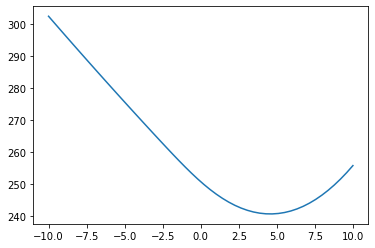

In [64]:
def gaussian(x, mean=0, var=1):
    return np.exp(-.5 * (x-mean)**2/var) / np.sqrt(2*np.pi*var)

def cdf(x):
    return 0.5 * erfc(- x / np.sqrt(2.0))

def loss(z):
    return - np.log( cdf(z) )

def moreau_loss(x, y, omega,V):
    return (x-omega)**2/(2*V) + loss(y*x)

def moreau_prime(x, y, omega, V):
        return (x - omega) / V - y * gaussian(x) / cdf(x * y)

def moreau_second(x, y, omega, V):
    return 1. / V -  y * (- x * gaussian(x) / cdf(x * y) - y * gaussian(x)**2 / cdf(x * y)**2)


omega = 100.0
V = 20.0
y = -1.0

root = root_scalar(lambda x : moreau_prime(x, y, omega, V),
                         fprime = lambda x : moreau_second(x, y, omega, V),
                         x0 = omega).root
mini = minimize_scalar(lambda x: moreau_loss(x, y, omega, V))['x']

plt.plot(vals, moreau_loss(vals, y, omega, V))

print(root, mini)